# The Rosendrock method

How to use the module

In [1]:
#I will make the jacobian passed as input in ROS.
# If the jacobian is singular for t->0^- you can use a "forward derivative".
# If the jacobian is singular for t->1^+ you can use a "backward derivative".

class Jacobian:
    def __init__(self,diffeq,h=1e-8):
        self.n=diffeq.n_eqs
        self.dydt=diffeq
        self.h=h
        
                   

    def __call__(self,y,t,J,dfdt):#J and dfdt are passed by "reference" it sould be initialized as J=0
        
        
        dydt0=self.dydt(y,t-self.h) 
        dydt1=self.dydt(y,t+self.h) 
        for i in range(self.n):
            dfdt[i]=(dydt1[i]-dydt0[i])/(2*self.h)
            

        for i in range(self.n):
            for j in range(self.n):
                #all y's are constant, except theit j component
                y0=y[:]
                y1=y[:]
                y0[j]=y[j]-self.h
                y1[j]=y[j]+self.h
                
                dydt0=self.dydt(y0,t) 
                dydt1=self.dydt(y1,t) 
                
                J[i][j]=(dydt1[i]-dydt0[i])/(2*self.h)


In [1]:



from Solver.Rosenbrock import Ros

In [3]:
import numpy as np

import matplotlib
#matplotlib.use('WebAgg')
#matplotlib.use('Qt4Cairo')
#matplotlib.use('Qt5Cairo')
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt

plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=10
plt.rcParams['mathtext.fontset']='stixsans'

In [4]:
#I'll use ROS3w fpr testing since I've the parameters ready.
class ROS3w:
    def __init__(self):
        #third stage, second order method
        self.s=3
        self.p=2
        self.c=[0,2/3.,4/3.]
        self.b=[0.25,0.25,0.5  ]
        self.bstar=[0.746704703274 , 0.1144064078371 , 0.1388888888888]
        self.a=[ [0 for j in range(self.s)] for i in range(self.s)]
        self.gamma=0.4358665215084 #this is gamma
        self.g=[ [0 for j in range(self.s)] for i in range(self.s)]#this is gamma_{ij}
        
        self.a[1][0]=2/3.
        self.a[2][0]=2/3.
        self.a[2][1]=2/3.
        
        self.g[1][0]=0.3635068368900
        self.g[2][0]=-0.8996866791992
        self.g[2][1]=-0.1537997822626
        
ros3w=ROS3w()

In [5]:
class diff_eq:
    def __init__(self,n=1):
        self.n_eqs=n
        
                   
    def __call__(self,y,t):
        return [-20*y[0]*t**3,
                5*y[0]*t**2+2*(-y[1]**2+y[2]**2)*t,  
                15*y[0]*t**2+2*(y[1]**2-y[2]**2)*t ]

    
dydt=diff_eq(3)

in0=[5,10,0]
JAC=Jacobian(dydt,h=1e-8)
sol=Ros(diffeq=dydt,init_cond=in0,RK_method=ros3w,Jacobian=JAC,
                      initial_step_size=1e-4,minimum_step_size=1e-11,maximum_step_size=1e-2,
                      maximum_No_steps=100000,absolute_tolerance=1e-5,relative_tolerance=1e-5,
                      beta=0.85,fac_max=3)

In [6]:
# %%timeit -n 1 -r 1
sol.solve()

<IPython.core.display.Javascript object>


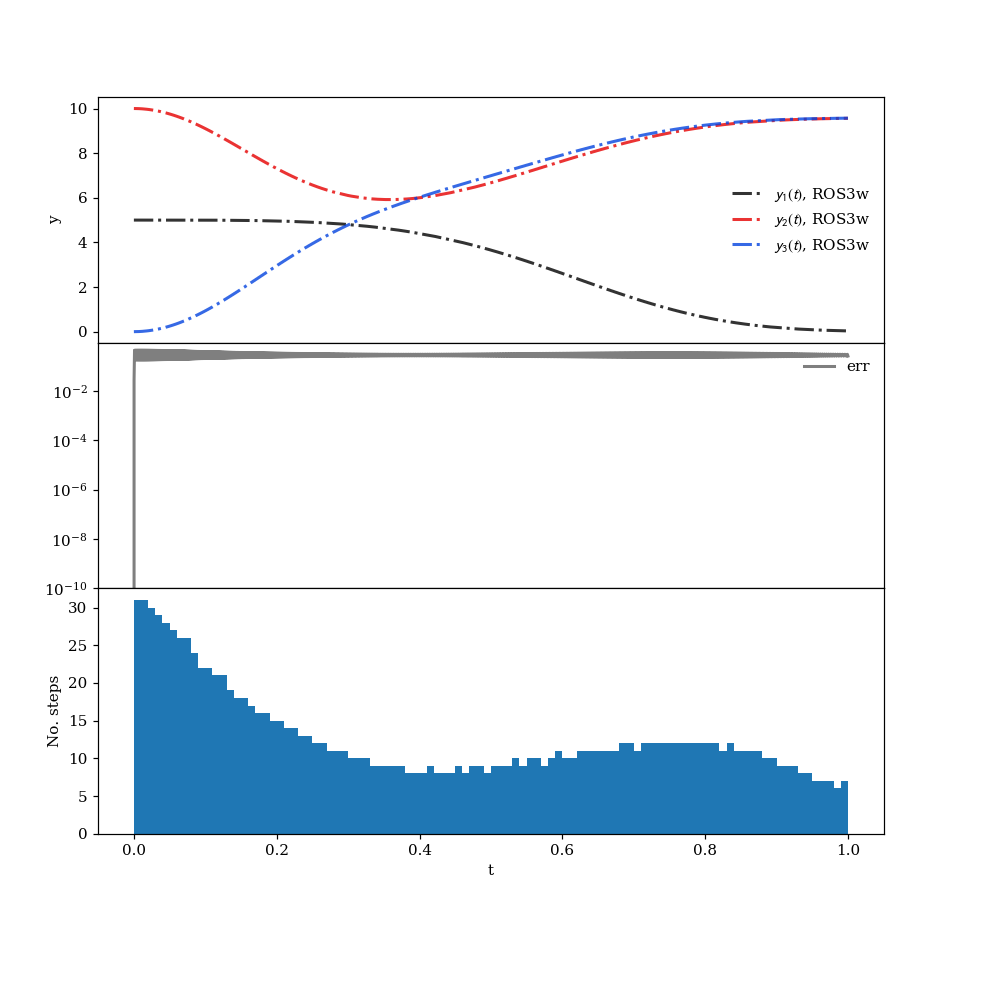

In [7]:
fig=plt.figure(figsize=(9,9))
fig.subplots_adjust(bottom=0.15, left=0.1, top = 0.9, right=0.9,wspace=0.0,hspace=0.0)
fig.suptitle('')



_c=['xkcd:black','xkcd:red','xkcd:blue']
sub = fig.add_subplot(311)
for i in range(len(sol.y)):
    sub.plot(sol.t,sol.y[i],c=_c[i],alpha=0.8,linestyle='-.',linewidth=2,label=r'$y_{'+str(i+1)+'}(t)$, ROS3w') 
    #sub.scatter(sol1.t,sol1.y[i],c=_c[i],marker='.',alpha=0.5,s=0.05) 
    sub.set_ylabel('y')  
sub.legend(framealpha=0,ncol=1,loc='center right',bbox_to_anchor=(1,0.5))

sub = fig.add_subplot(312)    
sub.plot(sol.t,sol.deltas,c=_c[0],alpha=0.5,linestyle='-',linewidth=2,label="err")
sub.legend(framealpha=0,ncol=2,loc='center right',bbox_to_anchor=(1,.9))

    
if max(sol.deltas) != 0 and max(sol.deltas) != 0: 
    sub.set_ylim(max([min(sol.deltas),1e-10]),max(sol.deltas)*2 )
    sub.set_yscale('log')
else:
    sub.set_ylim(max([min(sol.deltas[0]),min(sol.deltas[1]) ] ) ,max([max(sol.deltas[0]),max(sol.deltas[1])]) )


sub = fig.add_subplot(313)    
sub.hist(sol.t,bins=100)
sub.set_ylabel('No. steps')
    
sub.set_xlabel('t')  


plt.show()